In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os

from sklearn.mixture import GaussianMixture

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

# Gaussian Mixture model example
- Works for a 3D spectral datacube, clusters data cube based on spectra morphology (see Kabanovic+2020 for a description)
- Here, the GMM clustering is applied to RCW 79

In [3]:
#### User input ####

## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## plotting options 
dpi_val = 300
path_plots = 'plots/'
save_name = 'GMM_RCW79.pdf'

## input for the Gaussian Mixture Models
n_comps_min = 2
n_comps_max = 9#11
seed_val = 312
threshold = 0.001
gmm_iter = 1000

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

########################

## Execute the script

In [4]:
## get the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5


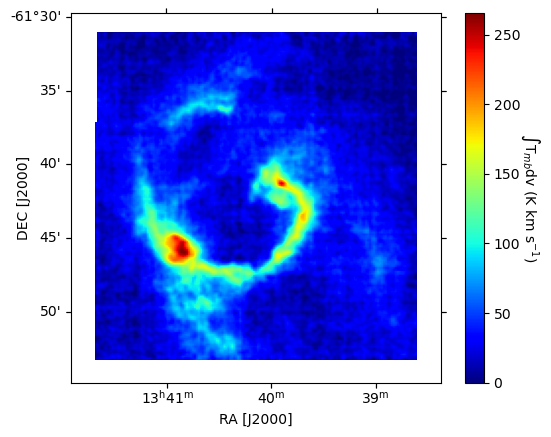

In [5]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity)

In [6]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

## prepare the data before the GMM loop
index_array, data_resampled = fGMM.prepare_data(data_reduced, min_velocity, max_velocity, crval, dv, crpix)

## loop over number of clusters for the GMM modeling
n_comps_list = []
bic_list = []
bic_min = None
best_model = None
for i in range(n_comps_min,n_comps_max):
    ## perform the GMM fitting
    print("Calculating GMM for {index} number of components".format(index = i))
    #temp_model = fGMM.run_GMM(data_resampled, i, seed_val, threshold, gmm_iter)
    temp_model = GaussianMixture(n_components=i, init_params='kmeans', covariance_type='full', random_state=seed_val, tol=threshold, max_iter=gmm_iter).fit(data_resampled)
    temp_bic = temp_model.bic(data_resampled)
    
    ## store the best fitting model
    if(i == n_comps_min or temp_bic < bic_min):
        best_model = temp_model
        bic_min = temp_bic
    n_comps_list.append(i)
    bic_list.append(temp_bic)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130
Dimensions of resampled data: (90, 35344)
Calculating GMM for 2 number of components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:26: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


Calculating GMM for 3 number of components
Calculating GMM for 4 number of components
Calculating GMM for 5 number of components
Calculating GMM for 6 number of components
Calculating GMM for 7 number of components
Calculating GMM for 8 number of components


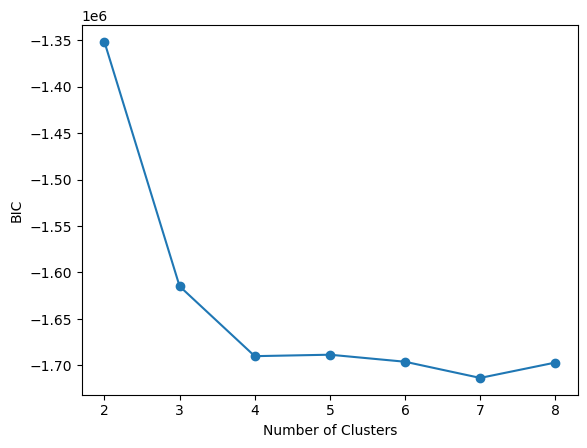

In [7]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comps_list,bic_list,"Number of Clusters","BIC")

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


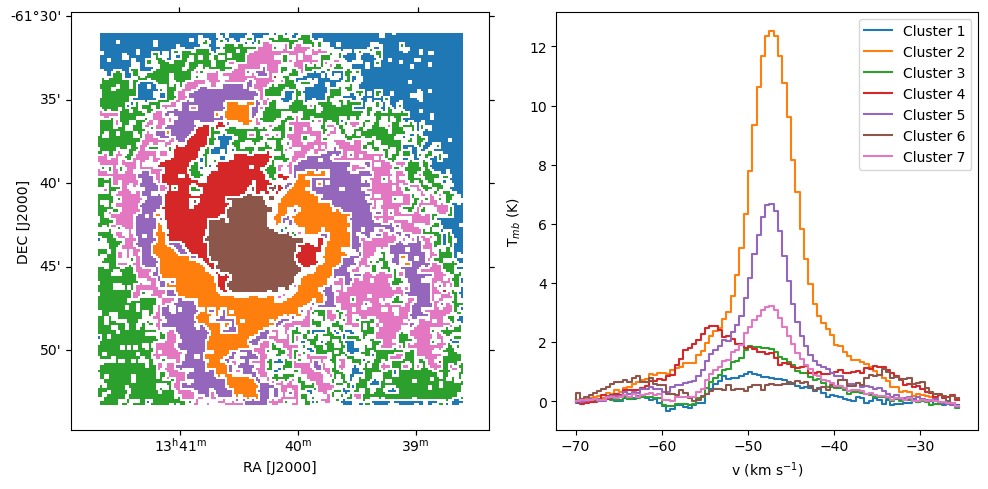

In [8]:
## Obtain the indices for the different clusters
cluster_inds = best_model.predict(data_resampled)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, plot_path = path_plots + save_name)

